In [1]:
import pickle

import numpy as np
import pandas as pd

import hist
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep
%matplotlib inline
mpl.style.use(mplhep.style.ROOT)

In [2]:
with open('roacc-with-2016-lumi.pkl','rb') as f:
    d = pickle.load(f)

In [20]:
r = d['roacc']
r['readout_eff'] = r['readout']/r['num_thrown']

rdmchis = list(np.unique(r.rdmchi))
rdmchis.sort()
colors = { r : c for r,c in zip(rdmchis, list(mpl.colors.TABLEAU_COLORS.keys())[:len(rdmchis)])}
    
rmaps = list(np.unique(r.rmap))
rmaps.sort()
markers = { r : m for r, m in zip(rmaps, mpl.lines.Line2D.filled_markers[1:len(rmaps)+1]) }

def cartesian_product(*arrays):
    la = len(arrays)
    #dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la]) #, dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

def eps2_mchi_heatmap(
    zaxis, *,
    filename = None,
    zmin = 1e-4, 
    zmax = 1e4
):
    fig, axes = plt.subplots(
        nrows=len(rdmchis),
        ncols=len(rmaps),
        sharex = 'col',
        sharey = 'row',
        figsize = (7*len(rmaps),7*len(rdmchis)),
        gridspec_kw = dict(
            wspace = 0.05,
            hspace = 0.05
        )
    )
    
    for (rdmchi, rmap), ax in zip(
        cartesian_product(rdmchis, rmaps),
        axes.flatten()
    ):
        sl = r[(
            (r.rdmchi==rdmchi)
            &(r.rmap==rmap)
        )]
        zero_events = np.isnan(sl[zaxis])|~np.any(sl[zaxis])|(sl[zaxis] < zmin)
        ax.scatter(sl.mchi[zero_events], sl.eps2[zero_events],
                   color='gray')
        im = ax.scatter(sl.mchi[~zero_events], sl.eps2[~zero_events], c=sl[zaxis][~zero_events],
                        norm=mpl.colors.LogNorm(zmin, zmax),
                        cmap='RdYlGn')
        ax.set_yscale('log')
        ax.set_xlim(xmin=5,xmax=135)
    
    for rmap, ax in zip(rmaps, axes[0]):
        ax.set_title(f'$m_A = {rmap}m_\\chi$')
    
    for irow, rdmchi in enumerate(rdmchis):
        axes[irow][0].set_ylabel(f'$\Delta = {rdmchi}m_\\chi$        $\epsilon^2$')
        
    for ax in axes[-1]:
        ax.set_xlabel('$m_\\chi$ [MeV]')
    
    fig.subplots_adjust(right=0.84)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax, label='Expected Events')
    if filename is not None:
        fig.savefig(filename, bbox_inches='tight')
    plt.show()


def mchi_scatter(
    df, yaxis, *,
    filename = None,
    ylabel = None,
    title = None
):
    fig, ax = plt.subplots()
    
    for rdmchi, color in colors.items():
        for rmap, marker in markers.items():
            sl=df[(df.rdmchi==rdmchi)&(df.rmap==rmap)]
            if sum(sl[yaxis]) == 0:
                continue
            ax.scatter(sl.mchi, sl[yaxis],
                color = color,
                marker = marker
            )
    ax.set_yscale('log')
    
    legend_artists = []
    for rdmchi, color in colors.items():
        legend_artists.append(
            mpl.patches.Patch(
                facecolor=color, edgecolor=color, 
                label=f'$\\Delta = {rdmchi}m_\\chi$'
            )
        )
    for rmap, marker in markers.items():
        legend_artists.append(
            mpl.lines.Line2D(
                [0],[0],
                marker = marker, color='gray', lw=0,
                markersize=10,
                label=f'$m_{{A\'}}={rmap}m_\\chi$'
            )
        )
    
    fig.legend(
        title=title,
        handles=legend_artists,
        ncols=2,
        loc='lower center',
        bbox_to_anchor=(0.5,0.85)
    )
    
    ax.set_xlabel('$m_\\chi$ [MeV]')
    if ylabel is None:
        ylabel = yaxis
    ax.set_ylabel(ylabel)
    if filename is not None:
        fig.savefig(filename, bbox_inches='tight')
    plt.show()

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fd2a04e41d0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

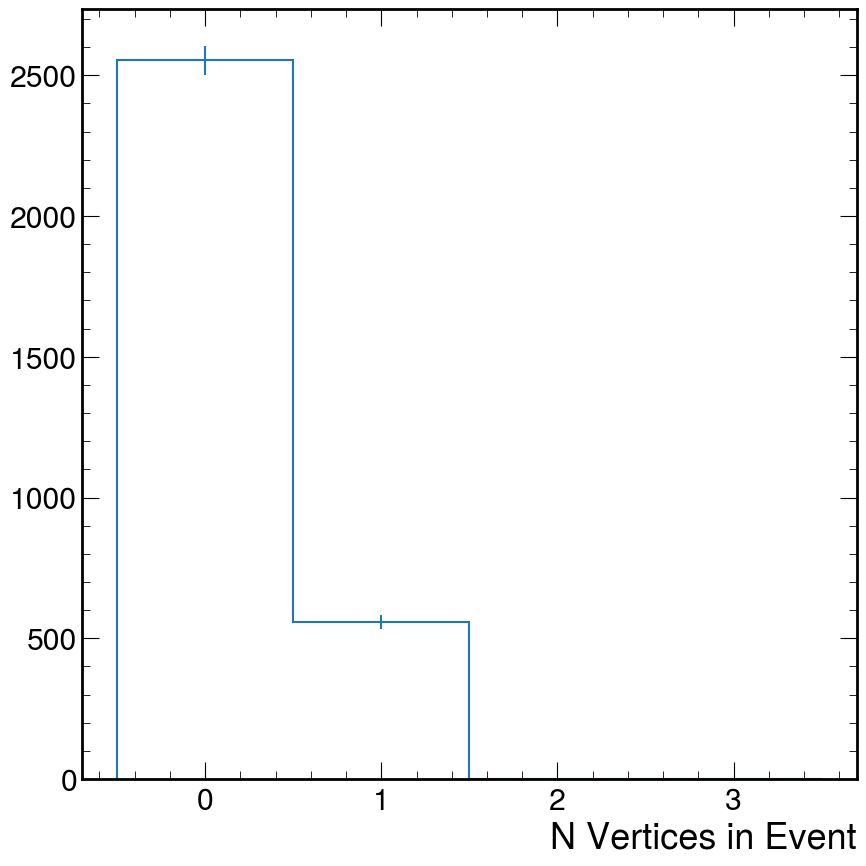

In [18]:
d[(50.0,0.6,3.0)]['n_vtx'].plot()

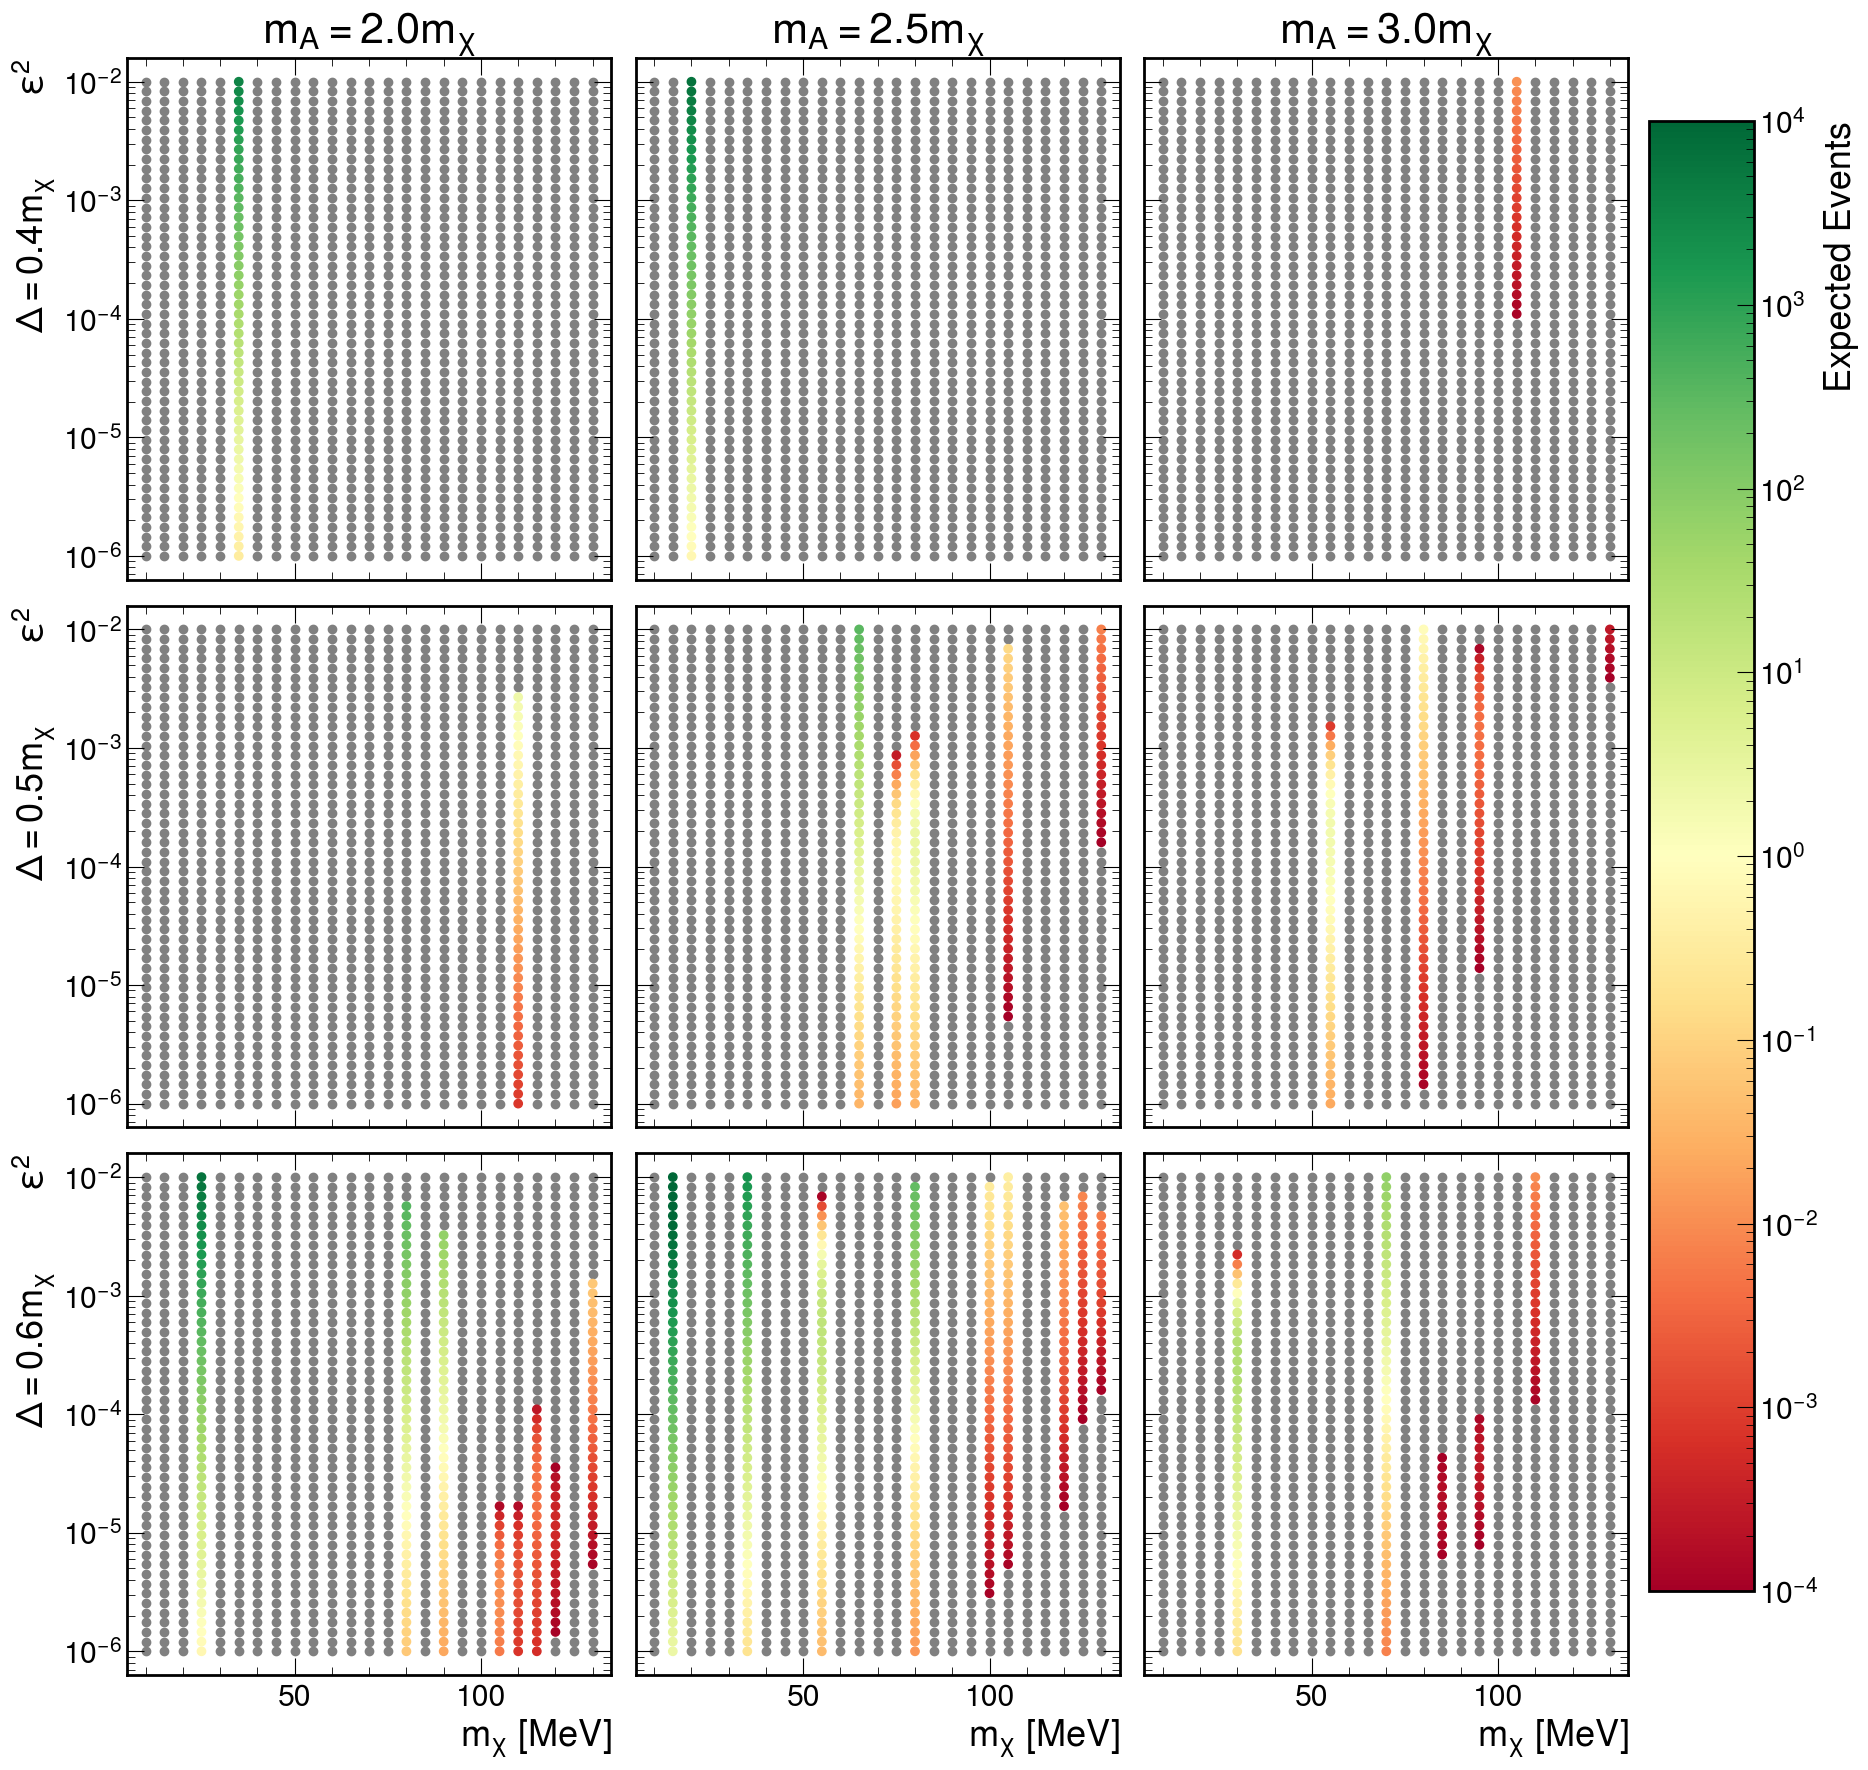

In [14]:
eps2_mchi_heatmap('std_full_rate')

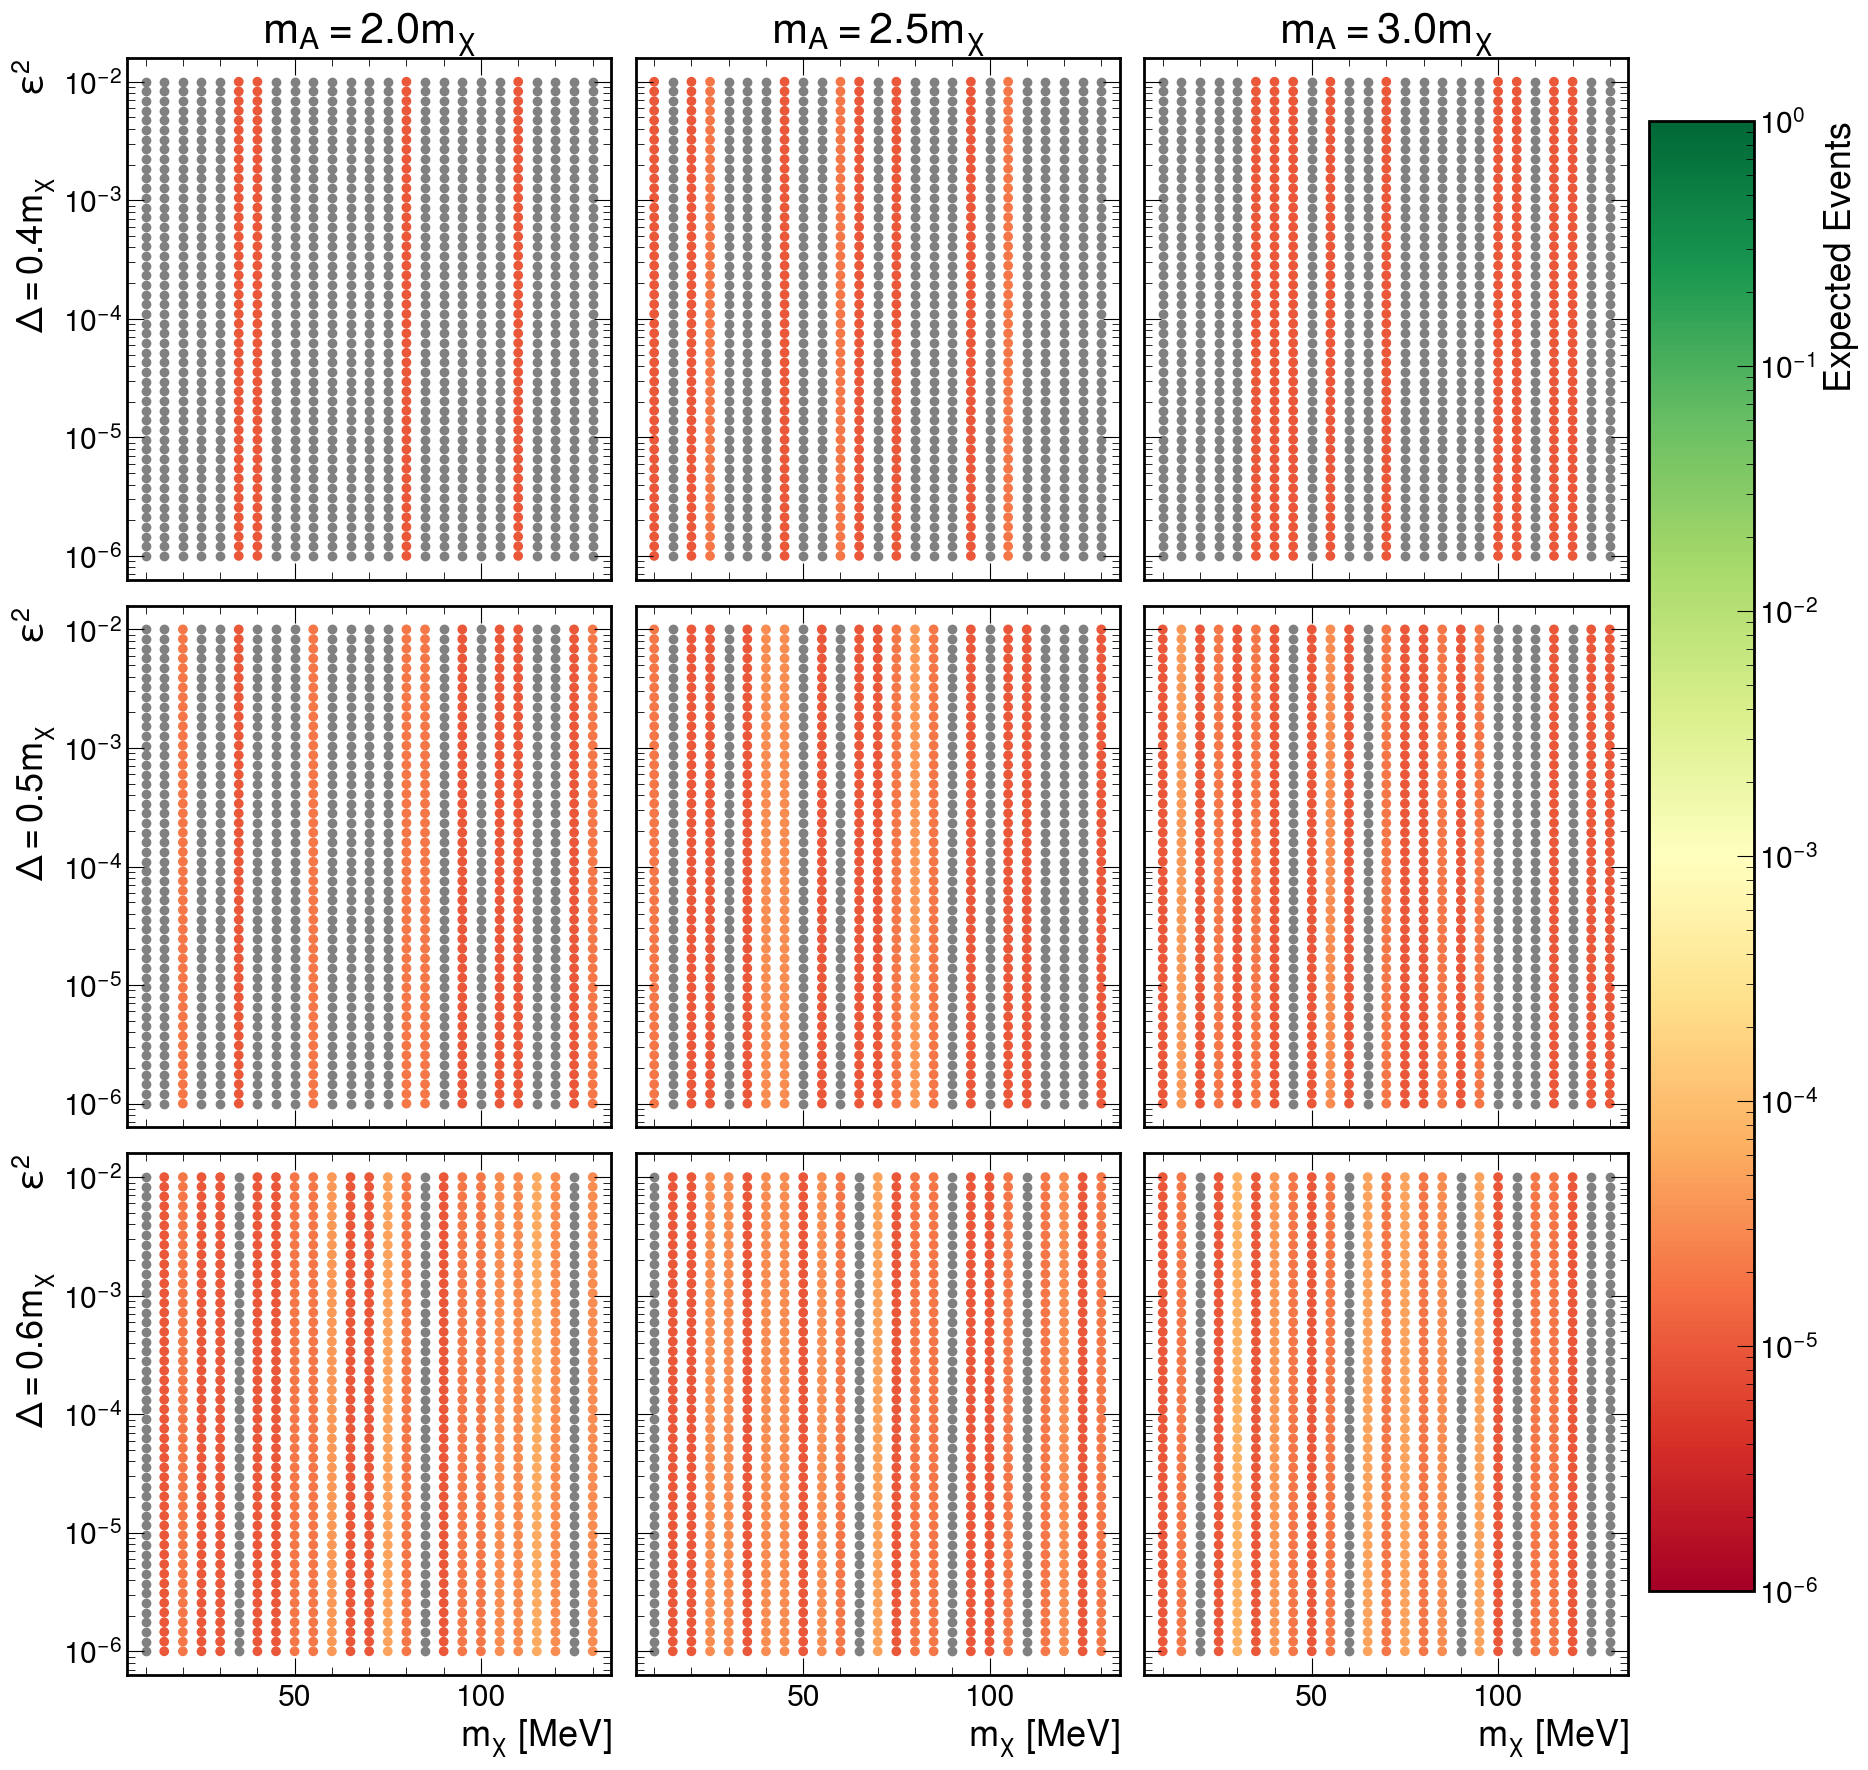

In [21]:
eps2_mchi_heatmap('std_event_selection_eff',zmin=1e-6,zmax=1)

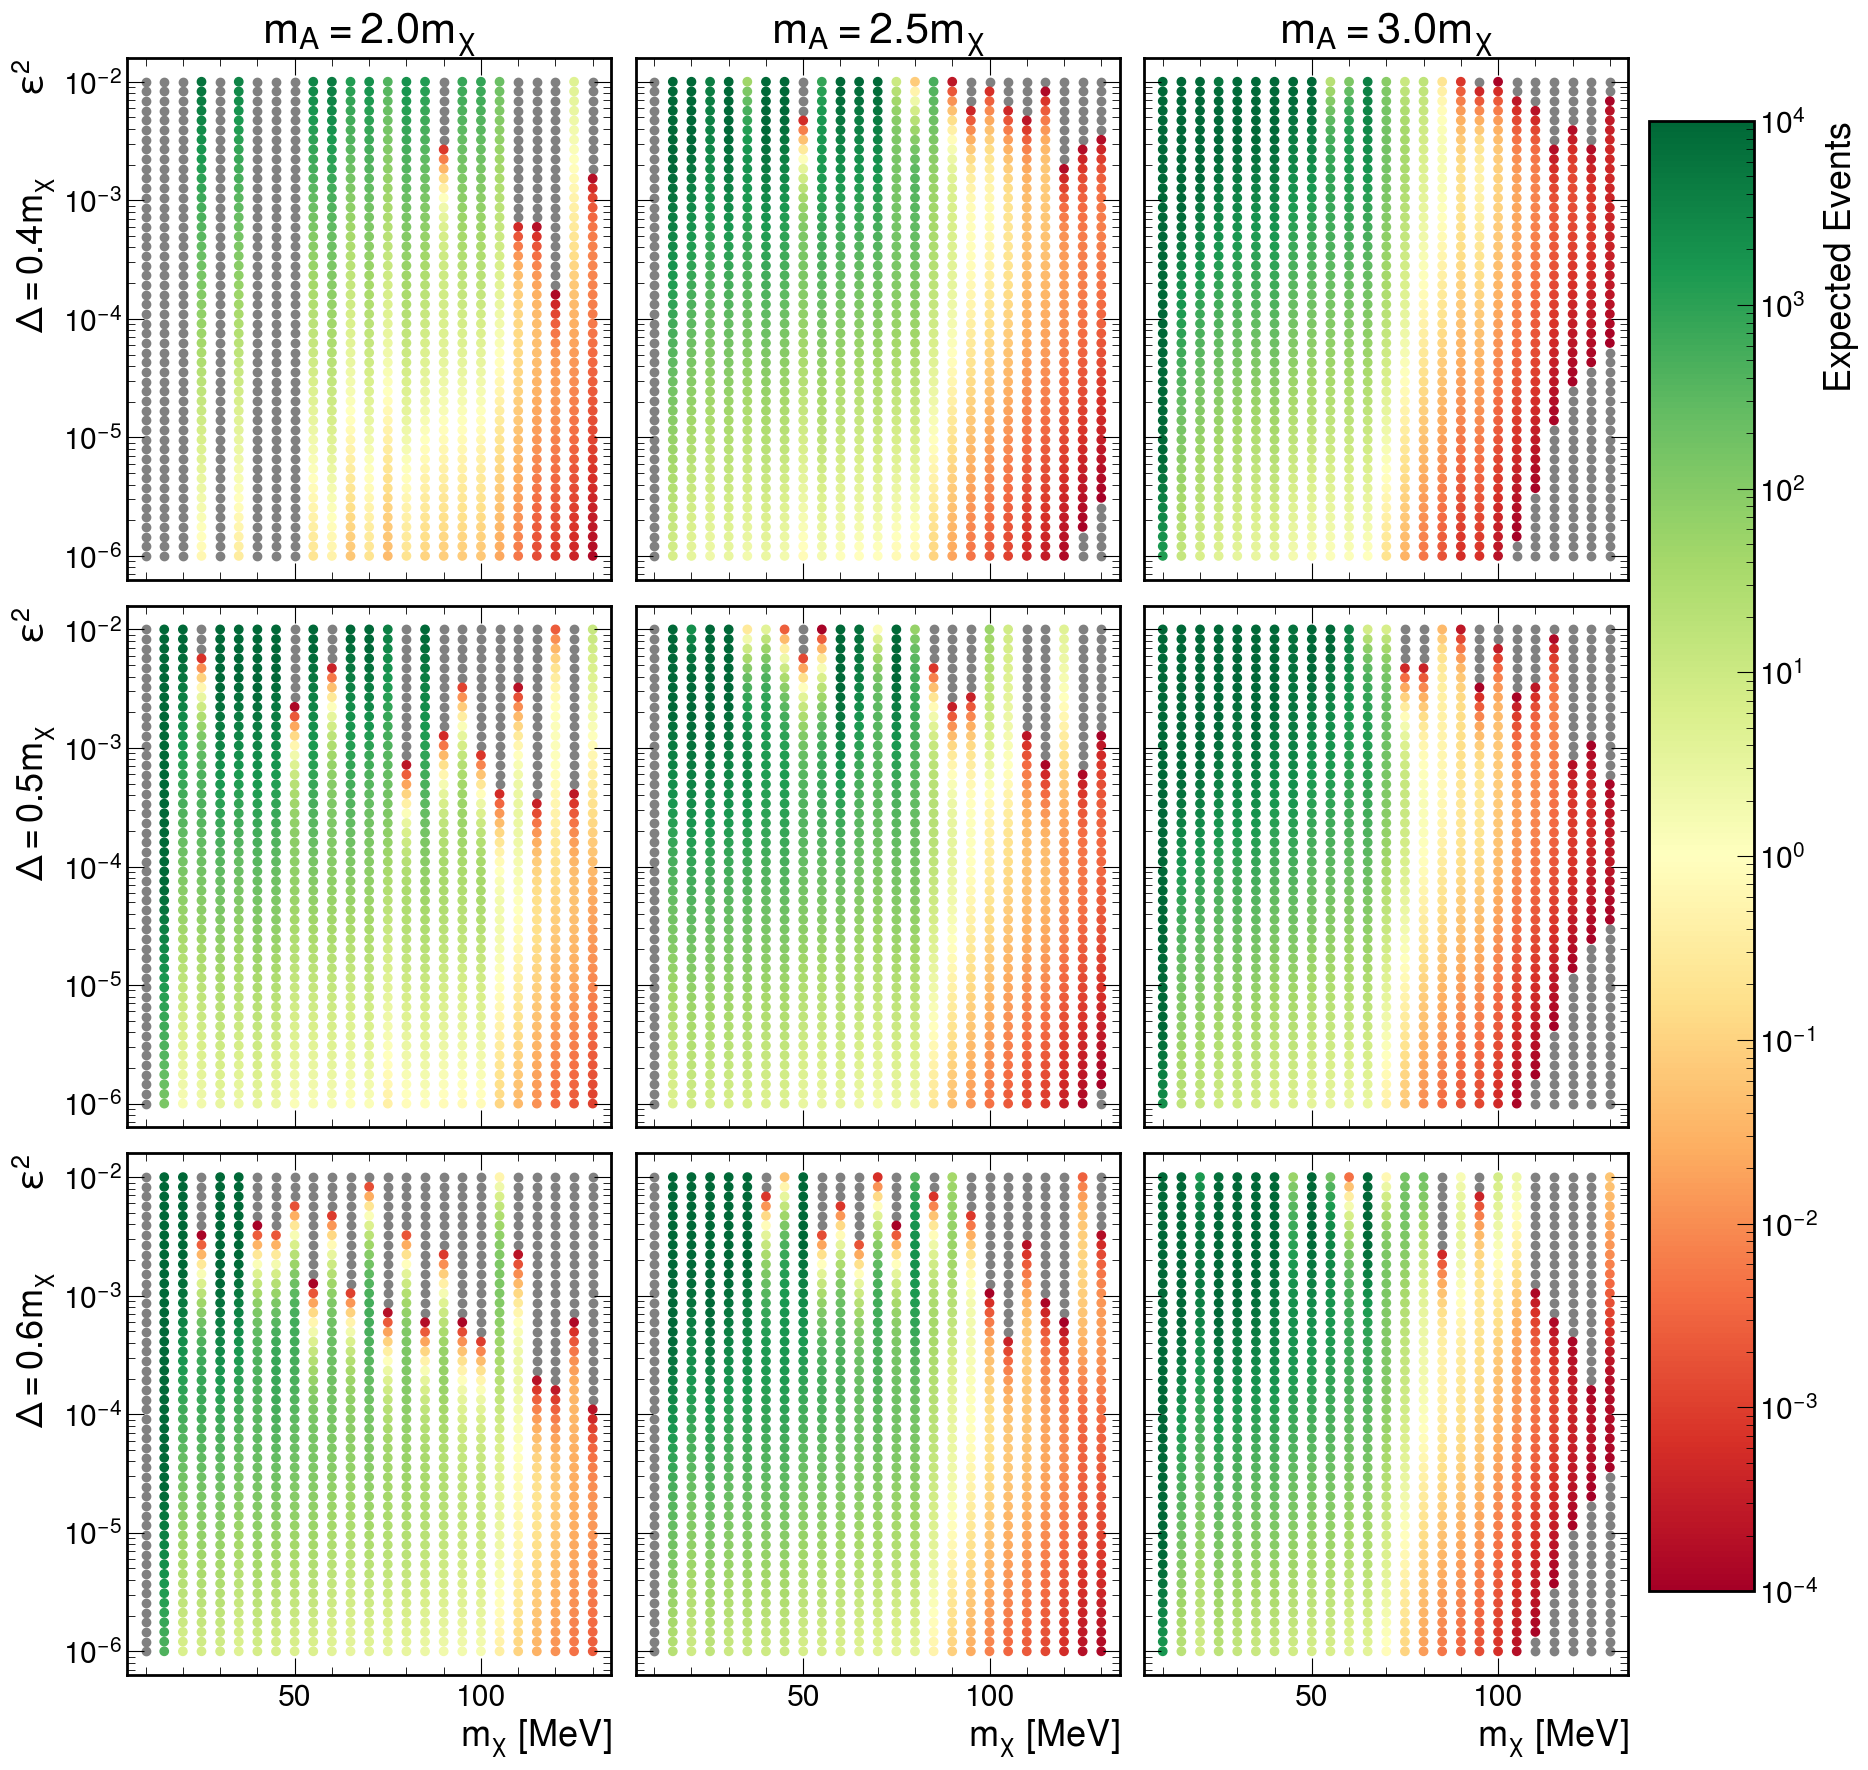

In [15]:
eps2_mchi_heatmap('mod_full_rate')

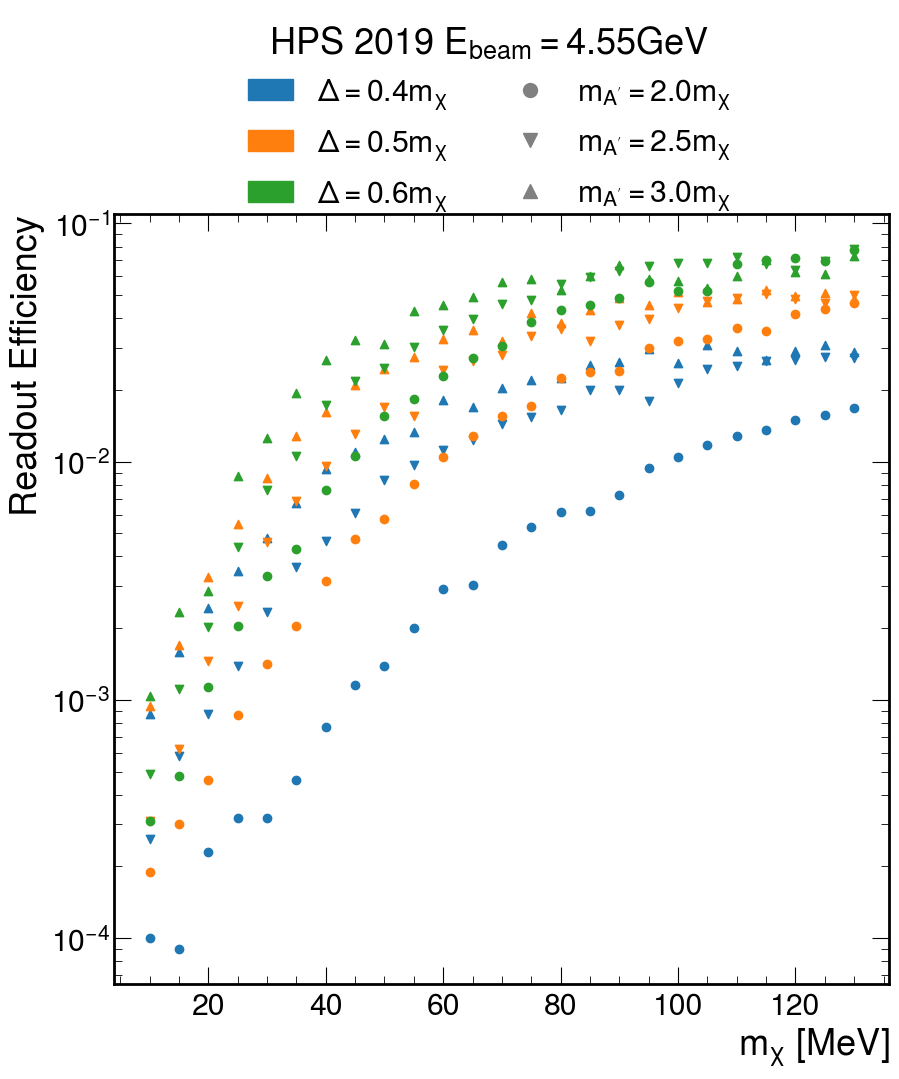

In [22]:
mchi_scatter(
    r.groupby(['rdmchi','rmap','mchi']).readout_eff.mean().reset_index(),
    'readout_eff',
    ylabel='Readout Efficiency',
    title='HPS 2019 $E_{beam}=4.55$GeV'
)